In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

print("Libraries Loaded.")


Libraries Loaded.


In [13]:
# Load Data
dataset_path = 'dhrona_data.csv'

if not os.path.exists(dataset_path):
    print(f"ERROR: '{dataset_path}' not found. Please upload it to Colab!")
else:
    df = pd.read_csv(dataset_path)
    print(f"Dataset Loaded: {len(df)} samples")
    print(f" Gestures: {df['label'].unique()}")

    # Separate Features (Coordinates) and Labels (Gesture Names)
    X = df.drop('label', axis=1).values
    y = df['label'].values

Dataset Loaded: 2423 samples
 Gestures: ['attention' 'cancel' 'direction' 'phonecall' 'sit' 'squat' 'stand' 'walk']


In [15]:
# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels (Text -> Numbers -> One-Hot)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_encoded)

# Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
  X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

In [16]:
# BUILD NEURAL NETWORK
num_gestures = y_cat.shape[1]

model = Sequential([
    Dense(64, input_shape=(132,), activation='relu'),
    Dropout(0.2), # Prevents overfitting
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_gestures, activation='softmax')
])

model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
print("\nStarting Training...")
history = model.fit(
  X_train, y_train,
  epochs=50,
  batch_size=16,
  validation_data=(X_test, y_test),
  verbose=1
)
print("Training Complete.")


Starting Training...
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9820 - loss: 0.0455 - val_accuracy: 0.9918 - val_loss: 0.0199
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0170 - val_accuracy: 0.9979 - val_loss: 0.0095
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9886 - loss: 0.0217 - val_accuracy: 0.9959 - val_loss: 0.0053
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0096 - val_accuracy: 0.9959 - val_loss: 0.0120
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0

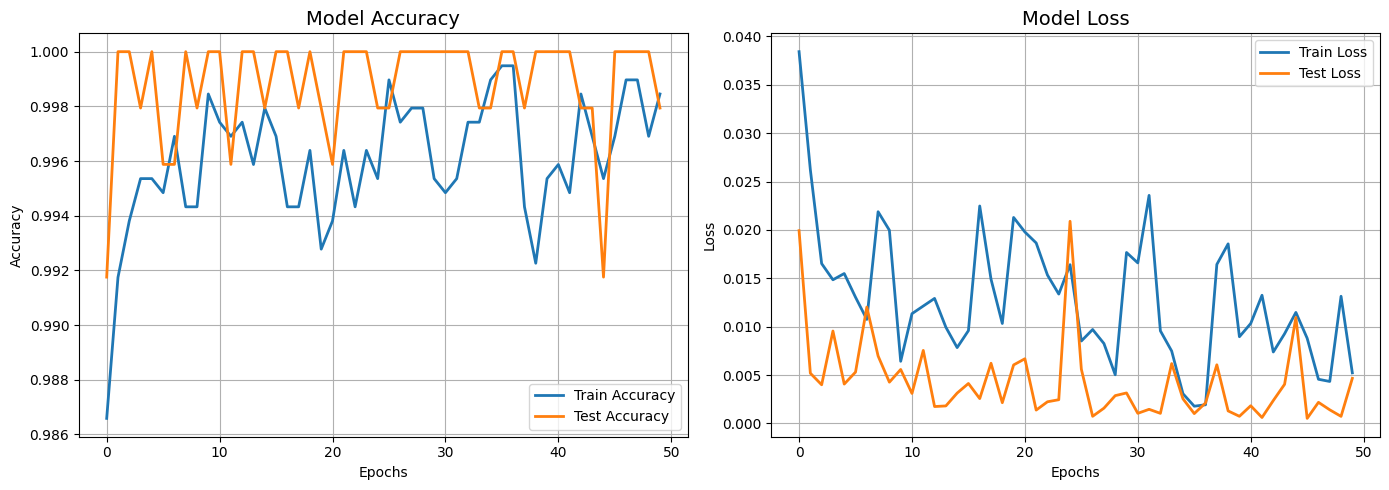

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


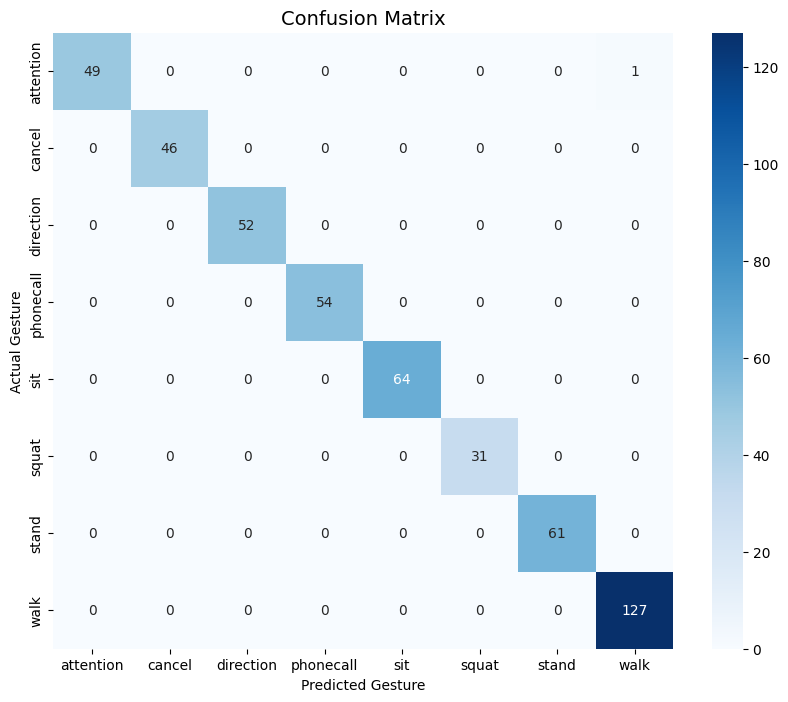


--- Classification Report ---
              precision    recall  f1-score   support

   attention       1.00      0.98      0.99        50
      cancel       1.00      1.00      1.00        46
   direction       1.00      1.00      1.00        52
   phonecall       1.00      1.00      1.00        54
         sit       1.00      1.00      1.00        64
       squat       1.00      1.00      1.00        31
       stand       1.00      1.00      1.00        61
        walk       0.99      1.00      1.00       127

    accuracy                           1.00       485
   macro avg       1.00      1.00      1.00       485
weighted avg       1.00      1.00      1.00       485



In [20]:
# Generate Report Graphs

# GRAPH 1: Accuracy & Loss Curves
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Test Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Test Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.savefig('report_accuracy.png', dpi=300) # Save high-res for report
plt.show()

# GRAPH 2: Confusion Matrix
# Get predictions on Test Data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
  xticklabels=encoder.classes_,
  yticklabels=encoder.classes_)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual Gesture')
plt.xlabel('Predicted Gesture')
plt.savefig('report_matrix.png', dpi=300)
plt.show()

# Print Statistics
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

In [21]:
# 6. Download Files
print("\nSaving Model & Tools...")
model.save('dhrona_model.h5')

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('encoder.pkl', 'wb') as f:
      pickle.dump(encoder, f)

print("Downloading files to your computer...")
files.download('dhrona_model.h5')
files.download('scaler.pkl')
files.download('encoder.pkl')
files.download('report_accuracy.png')
files.download('report_matrix.png')


Saving Model & Tools...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>